# Energy

Microstate energy:
$$E_t = -\frac{1}{2}\sum^N_{\langle i,j\rangle} J_{i,j}\;s_is_j-B\sum^N_i s_i$$

Mean energy:
$$\langle E\rangle= \frac{1}{\tau}\sum^{\tau}_t E_t$$

# Specific Heat Capacity

$$C= \left(\frac{\partial E}{\partial T} \right)_{P,B}$$ 

# Magnetization

Microstate magnetization:
$$M = \mu \sum^N_i s_i$$

Mean magnetization:
$$\langle M\rangle= \frac{1}{\tau}\sum^{\tau}_t M_t$$

# Susceptibility:

General:
$$\chi = \left(\frac{\partial M}{\partial B} \right)_T $$

At $B\rightarrow 0$:
$$\chi = \beta\left[\langle M^2\rangle - \langle M\rangle^2\right]$$

# State Probabilities

Partition function:
$$\sum^{\Omega}_{j=1}e^{-\beta E_i}$$

Microstate probability:
$$\rho_i = \frac{1}{Z}e^{-\beta E_i}$$

Transition ratio:
$$\rho = \frac{\rho_{i+1}}{\rho_i} = \frac{\frac{1}{Z}e^{-\beta E_{i+1}}}{\frac{1}{Z}e^{-\beta E_i}} = e^{-\beta \Delta E}$$

# Metropolis Algorithm
1. While loop
    1. Make a random trial spin flip.
    2. Compute energy change $\Delta E$ via nearest neighbor interaction at site.
    3. If $\Delta E<0$, accept change.
    4. If $\Delta E>0$, apply transition probability $\rho$ to accept change.
    5. Equilibrium condition: $\langle \Delta E\rangle \approx 0$ over time range $\tau$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from numba import njit, prange
import time 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm
from scipy import signal
matplotlib.rcParams["text.usetex"] = True

In [2]:
## Interaction term kernels per each region
J_1 = np.array([[[0,0,0],
                 [0,1,0],
                 [0,0,0]],
                [[0,1,0],
                 [1,0,1],
                 [0,1,0]], 
                [[0,0,0],
                 [0,1,0],
                 [0,0,0]]])
J_2 = np.copy(J_1)
J_2[1,1,2] = -1
J_3 = np.copy(J_1)
J_3[1,1] *= -1
J_4 = np.copy(J_1)
J_4[1,1,0] = -1
J_5 = -1*np.copy(J_3)


## Determines total energy of interaction at a localized lattice point i 
@njit
def local_E(spin_i, local, J, B, half=False):
    E_j = -spin_i*J*local
    
    #Keyword 'half'=True handles the case of double counting coupling E, when summing total E of system
    if half == True:
        E_ij = 0.5*np.sum(E_j) - B*spin_i
    else:
        E_ij = np.sum(E_j) - B*spin_i

    return E_ij


## Find initial total energy of system
@njit
def init_E(lattice, J_array, B, shape):
    tot_E = 0

    for i in np.arange(shape[0]):
        for j in np.arange(shape[1]):
            for k in np.arange(shape[2]):
                local = lattice[i:i+3, j:j+3, k:k+3]
                E_ij = local_E(local[1,1,1], local, J_array[i,j,k], B, half=True)
                tot_E += E_ij

    return tot_E

## Find initial total magnetization
@njit
def init_M(lattice):
    return np.sum(lattice)

## Generate random position of spin flip
@njit
def randflip(shape, current_state):

    i = np.random.randint(shape[0])
    j = np.random.randint(shape[1])
    k = np.random.randint(shape[2])
    local = current_state[i:i+3, j:j+3, k:k+3]
    spin_i = local[1,1,1]
    
    return i,j,k, spin_i, local


@njit
def run1(state, macro_data, m_planes, J_array, tau, beta, B):  
    # [x+2][y+2][n+2], [t][delE, E, M, M_0:M_n], [M, M_0:M_n], [x][y][n][J_i][J_j][J_k], int, float, float

    #Calculate initial conditions for macro_data
    macro_data[0][1] = init_E(state, J_array, B, shape)
    for p in range(shape[2]):
        macro_data[0][p+3] = init_M(state[1:-1,1:-1,p+1])
    macro_data[0][2] = np.sum(macro_data[0][3:])

    
    # Run until equilibrium    
    equilibrium = False
    t=0

    while t<tau or not equilibrium:
    
        # Initialize next timestep
        macro_data = np.append(macro_data, macro_data[-1:],0)

        # Random trial flip [i,j,k]            
        i,j,k, spin_i, local = randflip(shape, state)
        J_kernel = J_array[i,j,k]
        
        # Calculate energy change
        E1 = local_E(spin_i, local, J_kernel, B)
        E2 = local_E(-spin_i, local, J_kernel, B)
        delE = E2-E1

            
        # Spin flip acceptance check
        if delE < 0:
            flip_check=True
        else:
            random = np.random.rand()
            rho = np.exp(-beta*delE)
            if random < rho:
                flip_check=True
            else:
                flip_check=False
                
        if flip_check==True:
            # Apply spin flip
            state[i+1,j+1,k+1] = -spin_i
            macro_data[-1,0] = delE
            macro_data[-1,1] = macro_data[-2,1]+delE
            macro_data[-1,2] = macro_data[-2,2]-2*spin_i
            macro_data[-1,3+k] = macro_data[-2,3+k]-2*spin_i

            # Periodic boundary case
            if i == 0:
                state[-1,j+1,k+1] = -spin_i
            if i == shape[0]:
                state[0,j+1,k+1] = -spin_i
            if j == 0:
                state[i+1,-1,k+1] = -spin_i
            if j == shape[1]:
                state[i+1,0,k+1] = -spin_i
            if k == 0:
                state[i+1,j+1,-1] = -spin_i
            if k == shape[2]:
                state[i+1,j+1,0] = -spin_i
        else:
            # Apply no change
            macro_data[-1,0] = 0
        
        
        # Equilibrium condition test
        t+=1
        if t > tau:
            last_delE = macro_data[-tau:,0]
            avg_delE = np.mean(last_delE)
            if np.abs(avg_delE) < 0.01:
                equilibrium = True
                for p in range(shape[2]):
                    m_planes[p+1] = np.mean(macro_data[-tau:,3+p]) /(shape[0]*shape[1])
                m_planes[0] = np.mean(m_planes[1:])
                
    
    return m_planes    # [m, m_0:m_n]

## Multiple random initial lattice
@njit(parallel=True)
def multi_init(runs, state, macro_data, m_array, J_array, tau, beta, B):
    # int, [r][x+2][y+2][n+2], [r][t][delE, E, M, M_0:M_n], [r][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, float, float
    for r in prange(runs):
        m_array[r]  = run1(state[r], macro_data[r], m_array[r], J_array, tau, beta, B)
    return m_array

## Vary T
@njit
def multi_init_T(runs, state, macro_data, m_array, J_array, tau, beta, B):
    # int, [r][x+2][y+2][n+2], [T][r][t][delE, E, M, M_0:M_n], [T][r][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, [beta], float
    beta_size = beta.size
    
    for T in range(beta_size):
        print("T")
        m_array[T] = multi_init(runs, state, macro_data[T], m_array[T], J_array, tau, beta[T], B)

    return m_array

## Vary B
@njit
def multi_init_B(runs, state, macro_data, m_array, J_array, tau, beta, B):
    # int, [r][x+2][y+2][n+2], [B][r][t][delE, E, M, M_0:M_n], [B][r][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, float, [B]
    B_size = B.size
    
    for m in range(B_size):
        print("B")
        m_array[m] = multi_init(runs, state, macro_data[m], m_array[m], J_array, tau, beta, B[m])

    return m_array

## Vary T and B
@njit
def multi_init_phase(runs, state, macro_data, m_array, J_array, tau, beta, B):
    # int, [r][x+2][y+2][n+2], [T][B][r][t][delE, E, M, M_0:M_n], [T][B][r][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, [T], [B]
    beta_size = beta.size
    B_size = B.size

    for T in range(beta_size):
        print("T")
        for m in range(B_size):

            m_array[T][m] = multi_init(runs, state, macro_data[T][m], m_array[T][m], J_array, tau, beta[T], B[m])

    return m_array   # [T][B][r][m, m_0:m_n]

In [3]:
## Lattice Parameters
D = 5   # Layer thickness
P = 1   # Periods
x = 10
y = 10
n = 3*P*D  
shape = np.array([x,y,n])

## Simulation Parameters
tau = 2000   # Time length to average over
runs = 25

## Initialize arrays
state = np.zeros([runs, x+2, y+2, n+2])     #[z+2][y+2][x+2]
state[:,1:-1,1:-1,1:-1] = np.random.randint(2,size=(runs,x,y,n))*2-1     # Random Initial lattice microstate

## Periodic boundaries
state[:,0, 1:-1, 1:-1] = state[:,-2, 1:-1, 1:-1]
state[:,-1, 1:-1, 1:-1] = state[:,1, 1:-1, 1:-1]
state[:,1:-1, 0, 1:-1] = state[:,1:-1, -2, 1:-1]
state[:,1:-1, -1, 1:-1] = state[:,1:-1, 1, 1:-1]
state[:,1:-1, 1:-1, 0] = state[:,1:-1, 1:-1, -2]
state[:,1:-1, 1:-1, -1] = state[:,1:-1, 1:-1, 1]


## Heterostructure booleans
P_bool_a = [True]*D+[False]*2*D
n_bool_a = P*P_bool_a
P_bool_b = [False]*D+[True]*D+[False]*D
n_bool_b = P*P_bool_b
P_bool_c = [False]*2*D+[True]*D
n_bool_c = P*P_bool_c
P_bool_bb = [False]*(D+1)+[True]*(D-2)+[False]*(D+1)
n_bool_bb = P*P_bool_bb
P_bool_ba = [False]*D+[True]+[False]*(D-1)+[False]*D
n_bool_ba = P*P_bool_ba
P_bool_bc = [False]*D+[False]*(D-1)+[True]+[False]*D
n_bool_bc = P*P_bool_bc

## Interaction term array
J_array = np.zeros([x,y,n,3,3,3])      # Interaction term array
J_array[:,:,n_bool_a] = J_1
J_array[:,:,n_bool_ba] = J_2
J_array[:,:,n_bool_bb] = J_3
J_array[:,:,n_bool_bc] = J_4
J_array[:,:,n_bool_c] = J_5


# Vary T

In [95]:
## Run multiple trials with random initial lattice state, for different T

# Simulation parameters
Temp = np.linspace(0.2, 4, 20)
B = np.linspace(0, 4, 20)
beta = 1/Temp
beta_size = np.size(beta)

# Data arrays

macro_data = np.zeros([beta_size, runs, 1,3+n])
m_array1 = np.zeros([beta_size, runs,1+n])

start = time.time()
m_array1 = multi_init_T(runs, state, macro_data, m_array1, J_array, tau, beta, B[0])
end = time.time()
print(end - start)

avg_m_planes1 = np.mean(m_array1, 1)

T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
36.60172486305237


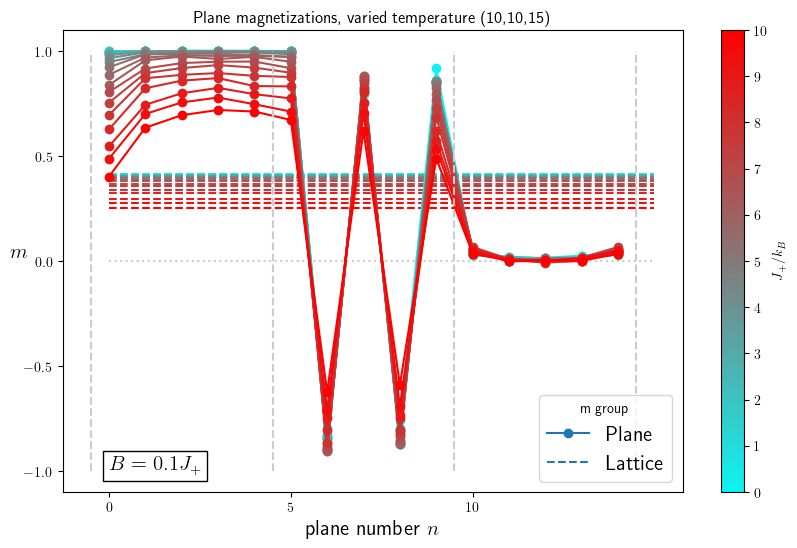

In [127]:
## Plot average magnetization of atomic planes

colors = np.array([1-np.arange(beta_size)/beta_size, np.arange(beta_size)/beta_size, np.arange(beta_size)/beta_size]).T
#value_colors = 
cmap = LinearSegmentedColormap.from_list('neon', colors[::-1], N=100)
fig,ax=plt.subplots(figsize=(10,6))

ax.hlines(0, 0, n, colors="0.8", linestyles="dotted")
for T in range(beta_size):
    ax.hlines(avg_m_planes1[T,0], 0, n, color=colors[beta_size-T-1], linestyles="dashed")
for T in range(beta_size):
    ax.plot(np.arange(n), avg_m_planes1[T,1:], 'o-', color=colors[beta_size-T-1], label=np.round(Temp[T],decimals=2))
    

ax.vlines((np.arange(3*P+1))*D-0.5, -1, 1, colors="0.8", linestyles="dashed")

ax.set_title(f"Plane magnetizations, varied temperature ({x},{y},{n})")
ax.set_xlabel("plane number $n$",fontsize=15)
ax.set_ylabel("$m$", rotation='horizontal',fontsize=15)
ax.set_xticks(np.arange(3*P)*D)
ax.set_yticks([1, 0.5, 0, -0.5, -1])
ax.text(0, -1, f"$B = {B[0]}J_+$", bbox=dict(facecolor='w', edgecolor='k'), fontsize=15)
#handles = [mpatches.Patch(color=color) for color in colors]
#leg1 = ax.legend(handles, Temp, title="$k_BT/J_+$")
#ax.add_artist(leg1)
handles = [mlines.Line2D([], [], marker='o', ls='-'), mlines.Line2D([], [], marker='', ls='--')]
ax.legend(handles, ['Plane', 'Lattice'],loc="lower right",title="m group",fontsize=15)
norm = Normalize(vmin=0,vmax=Temp[-1])
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, ticks=np.arange(11), label="$J_+/k_B$")
plt.savefig(f"Plane mags T ({x},{y},{n}).png")
plt.show()

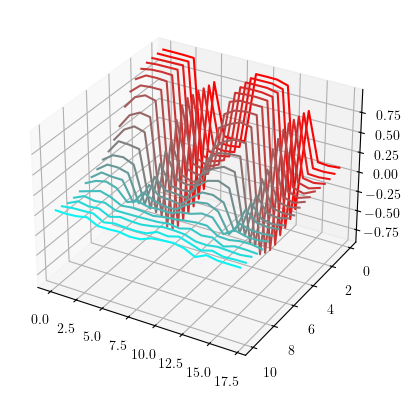

In [69]:
## Possible 3D graph of magnetization profiles
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.gca().invert_yaxis()
#for T in np.arange(beta_size):
#    ax.plot(np.arange(n), Temp[T]*np.ones(n), avg_m_planes1[T,1:], '-', color=colors[T][:-1], label=np.round(Temp[T],decimals=2))
X = np.arange(n)
Y = Temp
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, avg_m_planes1, color=colors[T][:-1])

# Vary B

In [6]:
## Run multiple trials with random initial lattice state, for different B

# Simulation parameters
Temp = np.linspace(0.1, 10, 20)
B = np.linspace(0.1, 4, 20)
beta = 1/Temp
B_size = np.size(B)

# Data arrays
macro_data = np.zeros([B_size, runs, 1,3+n])
m_array2 = np.zeros([B_size, runs,1+n])

start = time.time()
m_array2 = multi_init_B(runs, state, macro_data, m_array2, J_array, tau, beta[0], B)
end = time.time()
print(end - start)

avg_m_planes2 = np.mean(m_array2, 1)

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
332.274427652359


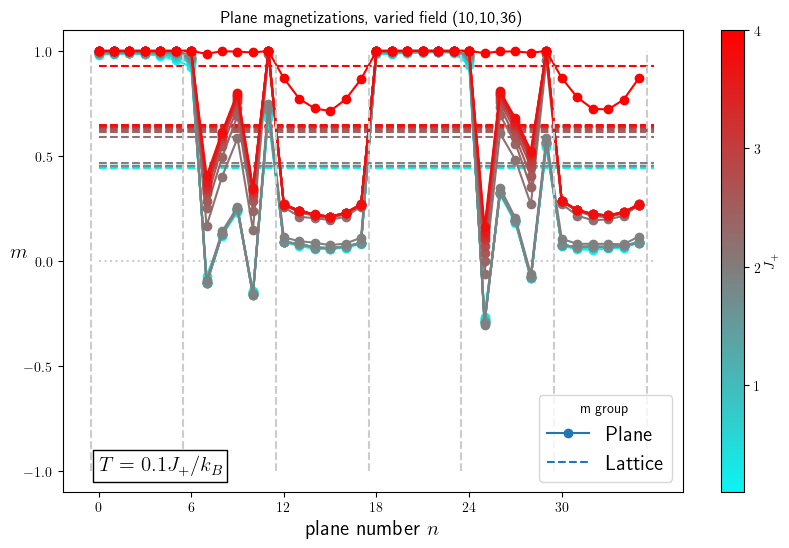

In [9]:
## Plot average magnetization of atomic planes

colors = np.array([1-np.arange(B_size)/B_size, np.arange(B_size)/B_size, np.arange(B_size)/B_size]).T
#value_colors = 
cmap = LinearSegmentedColormap.from_list('neon', colors[::-1], N=100)
fig,ax=plt.subplots(figsize=(10,6))

ax.hlines(0, 0, n, colors="0.8", linestyles="dotted")
for m in range(B_size):
    ax.hlines(avg_m_planes2[m,0], 0, n, color=colors[B_size-m-1], linestyles="dashed")
for m in range(B_size):
    ax.plot(np.arange(n), avg_m_planes2[m,1:], 'o-', color=colors[B_size-m-1], label=np.round(B[m],decimals=2))
    

ax.vlines((np.arange(3*P+1))*D-0.5, -1, 1, colors="0.8", linestyles="dashed")

ax.set_title(f"Plane magnetizations, varied field ({x},{y},{n})")
ax.set_xlabel("plane number $n$",fontsize=15)
ax.set_ylabel("$m$", rotation='horizontal',fontsize=15)
ax.set_xticks(np.arange(3*P)*D)
ax.set_yticks([1, 0.5, 0, -0.5, -1])
ax.text(0, -1, f"$T = {Temp[0]}J_+/k_B$", bbox=dict(facecolor='w', edgecolor='k'), fontsize=15)
#handles = [mpatches.Patch(color=color) for color in colors]
#leg1 = ax.legend(handles, Temp, title="$k_BT/J_+$")
#ax.add_artist(leg1)
handles = [mlines.Line2D([], [], marker='o', ls='-'), mlines.Line2D([], [], marker='', ls='--')]
ax.legend(handles, ['Plane', 'Lattice'],loc="lower right",title="m group",fontsize=15)
norm = Normalize(vmin=B[0],vmax=B[-1])
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, ticks=np.arange(11), label="$J_+$")
#plt.savefig(f"Plane mags B ({x},{y},{n}).png")
plt.show()

# Vary T and B

In [4]:
## Run multiple trials with random initial lattice state, for different T and B

# Simulation parameters
Temp = np.linspace(0.1, 10, 20)
B = np.linspace(0.1, 4, 20)
beta = 1/Temp
beta_size = np.size(beta)
B_size = np.size(B)

# Data arrays
macro_data = np.zeros([beta_size, B_size, runs, 1,3+n])
m_array3 = np.zeros([beta_size, B_size, runs,1+n])

start = time.time()
m_array3 = multi_init_phase(runs, state, macro_data, m_array3, J_array, tau, beta, B)
end = time.time()
print(end - start)

avg_m_planes3 = np.mean(m_array3, 2)   # [T][B][m, m_0:m_n]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
T
550.7565178871155


In [148]:
ferri_magnet = []
for T in range(beta_size):
    for m in range(B_size):
        if np.any(avg_m_planes3[T,m,1:], where=avg_m_planes3[T,m,1:]<-0.05):
            ferri_magnet.append([T,m])


lower_boundary = np.array([[0,0], [1,0], [2,0], [3,0], [4,0], [5,1], [6,1], [7,2], [8,1], [9,1], [10,1]])
upper_boundary = np.array([[0,11], [1,16], [2,15],[3,14],[4,13],[5,11],[6,10],[7,8],[8,6],[9,3], [10,1], [10,0]])
l_bound = []
u_bound = []


for i in range(np.shape(lower_boundary)[0]):
    #lower_boundary[i] =
    l_bound.append([Temp[lower_boundary[i,0]],B[lower_boundary[i,1]]])

for i in range(np.shape(upper_boundary)[0]):
    #lower_boundary[i] =
    u_bound.append([Temp[upper_boundary[i,0]],B[upper_boundary[i,1]]])

new = np.array([0, 0, 0, 0, 0, 0, 0])
new_B = Temp[4:11]

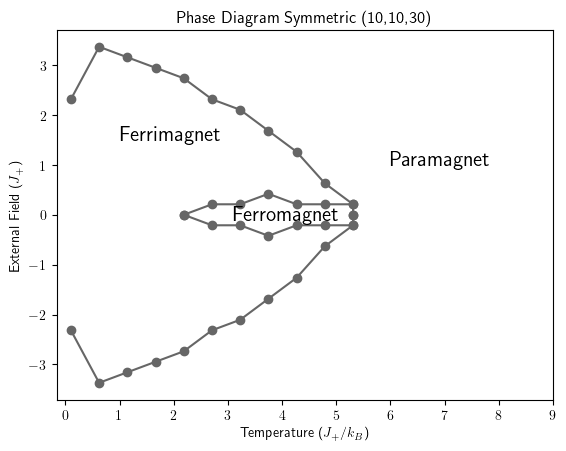

In [171]:
## Plotting Phase Diagrams

lower_bound = np.array(l_bound).T

upper_bound = np.array(u_bound).T

plt.plot(lower_bound[0][4:], lower_bound[1][4:], "o-", color="0.4")
plt.plot(upper_bound[0], upper_bound[1], "o-", color="0.4")
#plt.plot(new_B, new, "o-", color="0.4")

plt.plot(lower_bound[0][4:], -lower_bound[1][4:], "o-", color="0.4")
plt.plot(upper_bound[0], -upper_bound[1], "o-", color="0.4")

plt.title("Phase Diagram Symmetric (10,10,30)")
plt.xlabel("Temperature ($J_+/k_B$)")
plt.ylabel("External Field ($J_+$)")
plt.xticks(np.arange(0,10))
plt.text(1, 1.5, "Ferrimagnet", fontsize=15)
plt.text(3.1, -0.1, "Ferromagnet", fontsize=15)
plt.text(6, 1, "Paramagnet", fontsize=15)
plt.savefig("Phase Diagram Symmetric (10,10,30)")
plt.show()

# Hysteresis

In [10]:
@njit
def run2(state, macro_data, m_planes, J_array, tau, beta, B):  
    # [x+2][y+2][n+2], [t][delE, E, M, M_0:M_n], [M, M_0:M_n], [x][y][n][J_i][J_j][J_k], int, float, float

    #Calculate initial conditions for macro_data
    macro_data[0][1] = init_E(state, J_array, B, shape)
    for p in range(shape[2]):
        macro_data[0][p+3] = init_M(state[1:-1,1:-1,p+1])
    macro_data[0][2] = np.sum(macro_data[0][3:])
    
    # Run until equilibrium    
    equilibrium = False
    t=0

    while t<tau or not equilibrium:
    
        # Initialize next timestep
        macro_data = np.append(macro_data, macro_data[-1:],0)

        # Random trial flip [i,j,k]            
        i,j,k, spin_i, local = randflip(shape, state)
        J_kernel = J_array[i,j,k]
        
        # Calculate energy change
        E1 = local_E(spin_i, local, J_kernel, B)
        E2 = local_E(-spin_i, local, J_kernel, B)
        delE = E2-E1

            
        # Spin flip acceptance check
        if delE < 0:
            # Apply spin flip
            state[i+1,j+1,k+1] = -spin_i
            macro_data[-1,0] = delE
            macro_data[-1,1] = macro_data[-2,1]+delE
            macro_data[-1,2] = macro_data[-2,2]-2*spin_i
            macro_data[-1,3+k] = macro_data[-2,3+k]-2*spin_i
        else:
            random = np.random.rand()
            rho = np.exp(-beta*delE)
            if random < rho:
                # Apply spin flip
                state[i+1,j+1,k+1] = -spin_i
                macro_data[-1,0] = delE
                macro_data[-1,1] = macro_data[-2,1]+delE
                macro_data[-1,2] = macro_data[-2,2]-2*spin_i
                macro_data[-1,3+k] = macro_data[-2,3+k]-2*spin_i
            else:
                # Apply no change
                macro_data[-1,0] = 0

        t+=1
        # Equilibrium condition test
        if t > tau:
            last_delE = macro_data[-tau:,0]
            avg_delE = np.mean(last_delE)
            if np.abs(avg_delE) < 0.01:
                equilibrium = True
                for p in range(shape[2]):
                    m_planes[p+1] = np.mean(macro_data[-tau:,3+p]) /(shape[0]*shape[1])
                m_planes[0] = np.mean(m_planes[1:])
                print(t)
    
    return m_planes, state    # [m, m_0:m_n], [x+2][y+2][n+2]

@njit
def hysteresis(state, macro_data, m_planes, J_array, tau, beta, B):
    # [x+2][y+2][n+2], [t][delE, E, M, M_0:M_n], [B][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, float, [B]
    
    B_size = B.size
    macro = np.copy(macro_data)
    
    for m in np.arange(B_size):
        m_planes[m], state = run2(state, macro_data, m_planes[m], J_array, tau, beta, B[m])

    return m_planes   # [B][m, m_0:m_n]


@njit(parallel=True)
def multi_init_hysteresis(runs, state, macro_data, m_array, J_array, tau, beta, B):
    # [r], [x,y,n], [r][x+2][y+2][n+2], [r][t][delE, E, M, M_0:M_n], [r][B][m, m_0:m_n], [x][y][n][J_i][J_j][J_k], int, float, [B]

    for r in prange(runs):
        m_array[r]  = hysteresis(state[r], macro_data[r], m_array[r], J_array, tau, beta, B)

    return m_array   #[r][B][m, m_0:m_n]

In [11]:
## Sweep B for Hysteresis

## Triangle wave to sweep from B = 0 -> max -> min -> max
max_B = 6.5
factor = 15    # Number of B values to sweep through pi/2
density = 5*factor+1
tri = np.linspace(0,2.5*np.pi, density)
triangle = max_B*2*np.arcsin(np.sin(tri))/np.pi

# Simulation parameters
Temp = np.array([0.1, 1, 2, 3, 4, 5])
B = triangle
beta = 1/Temp
B_size = np.size(B)

macro_data = np.zeros([runs, 1,3+n])
m_array4 = np.zeros([runs, B_size, 1+n])

start = time.time()
m_array4 = multi_init_hysteresis(runs, state, macro_data, m_array4, J_array, tau, beta[0], B)
end = time.time()
print("Minutes",(end - start)/60)
print("Seconds",(end - start))

avg_m_planes4 = np.mean(m_array4, 0)

24468
5374
3319
2001
2889
5089
7907
2526
3437
28942
2001
2835
2327
2001
3876
13891
2001
3829
31299
5290
3861
2780
2001
6565
12388
31514
7963
2001
2001
2001
12860
9617
4224
5325
2833
4564
28794
32691
5457
2001
3049
6060
3093
3660
2001
2001
31228
3349
2632
31602
2001
2001
7213
3336
3593
2461
2226
7110
9594
5062
2522
13476
7080
4299
4744
2370
9657
9390
2587
17197
9827
2313
2001
8841
34103
2993
2001
2046
2131
4756
9550
35575
5960
2549
2001
2001
23555
16143
2913
2785
20155
3812
2001
2001
2001
2001
2001
2001
2001
2001
9691
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
31702
2001
2001
2001
2001
2001
2001
2001
2001
8148
6472
3609
36421
2955
3061
2001
2001
2731
3737
19854
6445
4793
9129
7597
16571
2602
2001
2937
2001
2001
2001
2001
16536
2001
2276
2001
2001
2133
2001
2001
16615
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
3720
2001
2001
2001
2001
2001
2001
2001
17725
3406
2971
2001
2001
2001
2001
2001
2001
2001
39076
2001
2001
2001
37104
2001
2001
2001
3887
2001
2001
2001
2418
200

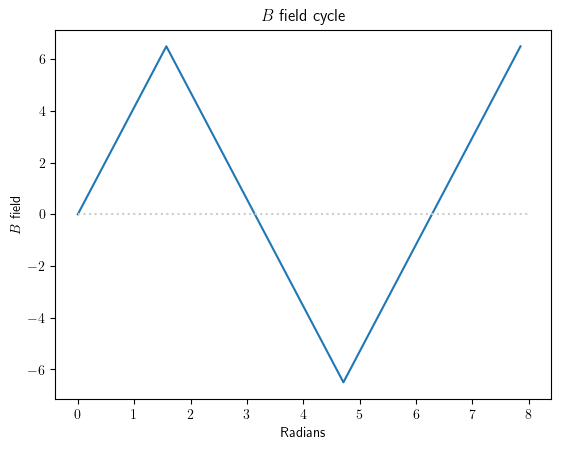

In [8]:
## Triangle wave to sweep from B = 0 -> max -> min -> max
max_B = 6.5
factor = 15    # Number of B values to sweep through pi/2
density = 5*factor+1
tri = np.linspace(0,2.5*np.pi, density)
triangle = max_B*2*np.arcsin(np.sin(tri))/np.pi

# Simulation parameters
Temp = np.array([0.1, 1, 2, 3, 4, 5])
B = triangle
plt.plot(tri, triangle)
plt.title("$B$ field cycle")
plt.xlabel("Radians")
plt.ylabel("$B$ field")
plt.hlines(0, 0, 8, colors="0.8", linestyles="dotted")
plt.savefig("Triangle Wave.png")

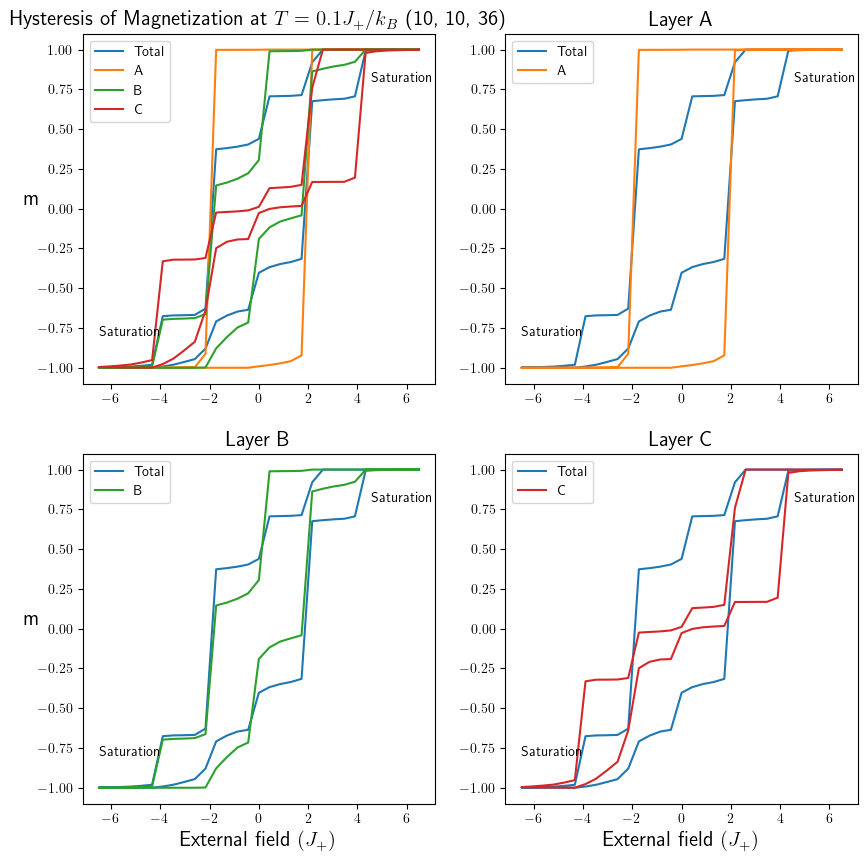

In [19]:
layer_a = avg_m_planes3[:,[False]+n_bool_a]
layer_b = avg_m_planes3[:,[False]+n_bool_b]
layer_c = avg_m_planes3[:,[False]+n_bool_c]
avg_m_layers = np.array([avg_m_planes3[:,0], np.mean(layer_a, 1), np.mean(layer_b, 1), np.mean(layer_c, 1)])
avg_m_layers = avg_m_layers[:,factor:]

fig,axs=plt.subplots(2,2, figsize=(10,10))

labels = ["Total", "A", "B", "C"]
line_colors = ['tab:orange', 'tab:green', 'tab:red']
for k in range(4):
    axs[0,0].plot(B[factor:],avg_m_layers[k,:], label=labels[k])
axs[0,0].set_title(f"Hysteresis of Magnetization at $T = {Temp[0]}J_+/k_B$ {x,y,n}", fontsize=15)
axs[0,0].text(0.70*np.max(B), 0.80, "Saturation") 
axs[0,0].text(1*np.min(B), -0.80, "Saturation")
axs[0,0].legend()

indices = [0,1,1,0,1,1]
for plot in range(3):
    u = indices[plot*2]
    v = indices[plot*2+1]
    axs[u,v].plot(B[factor:],avg_m_layers[0,:], label=labels[0])
    axs[u,v].plot(B[factor:],avg_m_layers[plot+1,:], label=labels[plot+1], color=line_colors[plot])
    axs[u,v].legend()
    axs[u,v].set_title(f"Layer {labels[plot+1]}", fontsize=15)
    axs[u,v].text(0.70*np.max(B), 0.80, "Saturation") 
    axs[u,v].text(1*np.min(B), -0.80, "Saturation")

axs[1,0].set_xlabel(r"External field $(J_+)$",fontsize=15)
axs[1,1].set_xlabel(r"External field $(J_+)$",fontsize=15)
axs[0,0].set_ylabel("m", rotation='horizontal', fontsize=15)
axs[1,0].set_ylabel("m", rotation='horizontal',fontsize=15)

plt.savefig(f"Hysteresis of Magnetization ({x},{y},{n}).png")
plt.show()